<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/4_SplittingDatasets_Duolingo_spaced_repetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Dataset splitting plan</font>

Previous notebooks covers data acquisition, deriving word and student based features, and in-depth EDA to understand how eah factor affects whether a word is forgotten in a review session.

To tackle the three questions asked in this project (listed below), the whole dataset is now split into 4 parts. 



To answer the following questions in order.

Q1) What makes words difficult or easy for a student to remember?

- The training set for Q1 is a closed set of some words and some students
- The test set for Q1 should consist of words not seen in the training data, but no new students.

Q2) What learning habits increase a student's retention?

- The training set for Q2 is a closed set of students, including all words from Q1 test and train. 
- The test set for Q2 should consist of students not seen in the training data

Q3) The cold-start problem: Duolingo is always adding new language courses, might good predictions based on learnings from Q1 and Q2 be possible for a NEW LANGUAGE?

- The test set for Q3 should consist of languages not seen in the training data, and may include new students, and will of course be made up of new words. 

The dataset will be split in the following manner (refer to image below)
INSERT HERE


Splitting the dataset will be done in reverse order:

1. first split - for Q3 testing - keep two languages aside for cold-start testing in Q3

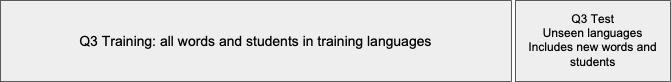
2. second split -for Q2 testing -  keep some unseen students aside for testing on seen words. (10%). include some regular and irregular students.

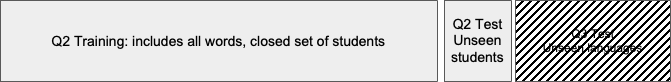
3. third split - for Q1 testing - keep some unseen words aside for testing on a closed set of  students. include some words that are sporadically practiced, and some heavily practiced (20%).

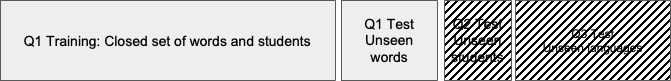
4. the rest. - for Q1 training -student word pairings left for Q1 training.

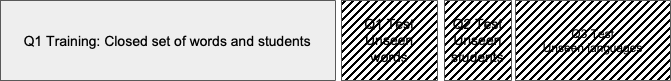   

Loading data:

In [ ]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Downloading the dataframe created and saved in notebook title: INSERT HERE
datadf = decompress_pickle(path_name+"Duolingo_pforgotbin.pbz2") 

In [ ]:
datadf.shape

(12854145, 16)

## <font color = 'cornflowerblue' size=4>Splitting Q3 - unseen languages</font>

Which languages are being learnt and by native speakers of which language?

In [ ]:
pd.crosstab(datadf['ui_language'],datadf['learning_language'])

learning_language,de,en,es,fr,it,pt
ui_language,,,,,,
en,1452597,0,3407654,1873716,793919,311480
es,0,3641167,0,0,0,0
it,0,424152,0,0,0,0
pt,0,949460,0,0,0,0


Lexical similarity - similarity of vocabulary, structure of sentences etc. 

English and German have a 60% lexical similarity, while English to Spanish is around 30% similar. On the other hand, the other languages are all fairly similar - French and Italian have 89% lexical similarity, Spanish and Portuguese are 89% similar, French and Portugese are 75% similar. So we need to split one language that is somewhat similar to the others, and one that is somewhat different, to see how learning one language's words can transfer to another when lexical similarities are low and high. 

The following lexical similarity values were taken from Wikipedia.

|    	| en      	| de   	| fr   	| es   	| it 	| pt 	|
|----	|---------	|------	|------	|------	|----	|----	|
| en 	| 1       	|      	|      	|      	|    	|    	|
| de 	| 0.6     	| 1    	|      	|      	|    	|    	|
| fr 	| 0.27    	| 0.29 	| 1    	|      	|    	|    	|
| es 	| ~   0.3 	|      	| 0.75 	| 1    	|    	|    	|
| it 	| ~   0.3 	|      	| 0.89 	| 0.82 	| 1  	|    	|
| pt 	| ~   0.3 	|      	| 0.75 	| 0.89 	|    	| 1  	|

For an example of a language not sharing too many words with the training set - keeping aside English to German.

Then we can keep aside one that is similar to the native languages - setting aside Italian to English.

In [ ]:
# separating out English to German:
coldstart_entode_df = datadf.loc[(datadf['learning_language']=='de') & (datadf['ui_language']=='en'),:]
coldstart_entode_df.shape

(1452597, 16)

The shape matches the number in the languages cross tab above. We will save this as a separate file.

Saving English (en) to German (de) as a separate test set.

In [ ]:
# coldstart_entode_df.to_csv("Coldstart_testset_entode.csv")
# from google.colab import files
# files.download("Coldstart_testset_entode.csv")
compressed_pickle(path_name+"Q3TEST_en_to_de",coldstart_entode_df)

Now we can delete it from the current set

In [ ]:
datadf = datadf.drop(coldstart_entode_df.index)

Next we separate out Italian to English. 

In [ ]:
coldstart_ittoen_df = datadf.loc[(datadf['learning_language']=='en') & (datadf['ui_language']=='it'),:]

In [ ]:
coldstart_ittoen_df.shape

(424152, 16)

The shape matches the number in the cross tab above. Now we save this as a separate test file, and delete those rows. 

In [ ]:
compressed_pickle(path_name+"Q3TEST_it_to_en",coldstart_ittoen_df)

The indices of Italian to English are deleted. 

In [ ]:
datadf = datadf.drop(coldstart_ittoen_df.index)

In [ ]:
datadf.shape

(10977396, 16)

Checking that the split dimensions add up:

In [ ]:
datadf.shape[0] + coldstart_ittoen_df.shape[0] + coldstart_entode_df.shape[0]

12854145

The dimensions add up to the shape of the original dataframe. The remainder will be the training set for the cold start question. 

Q3 TRAIN: 10977396
Q3 TEST EN_TO_DE : 1452597
Q3 TEST IT_TO_EN : 

In [ ]:
compressed_pickle(path_name+"Q3TRAIN",datadf)

The Q3 test sets are no longer needed for splitting, so they are deleted:

In [ ]:
del coldstart_ittoen_df, coldstart_entode_df

## <font color = 'cornflowerblue' size=4>Splitting for Q2 - unseen students</font>

Splitting Q3 train set further into Q2 train and test: 

Test set will include unseen students. 

Train and test set should have a similar distribution of records. 

Renaming datadf for avoiding confusion. 

In [ ]:
datadf2 = datadf

In [ ]:
datadf2['student_lang'] = datadf2[['user_id','ui_language']].apply(lambda x: (x[0],x[1]),axis=1)

In [ ]:
len(datadf2['student_lang'].unique()), len(datadf2['user_id'].unique()), len(datadf2['ui_language'].unique())

(99027, 98860, 3)

There are 99027 unique pairings of student and ui language, but only 98860 unique students. Surprisingly, there are some students studying from several native langugaes. let us look at them:

num_uilang will hold how many ui languages for each student

In [ ]:
num_uilang = datadf2.groupby('user_id')['ui_language'].unique().apply(len)

Filtering to students with more than one ui language

In [ ]:
num_uilang[num_uilang>1].sort_values (ascending=False)

user_id
u:-Ap     2
u:i7bd    2
u:i9Dt    2
u:iAG2    2
u:iBC7    2
         ..
u:gQM_    2
u:gWmp    2
u:gXXY    2
u:g_Dt    2
u:q6O     2
Name: ui_language, Length: 167, dtype: int64

There are several (167). Let's leave them in our training set. We will subset students from those who have only one native language and make our unseen student test set from there. 

In [ ]:
one_uilang_students = list(num_uilang[num_uilang==1].index)

We get the cross tabulation of number of students learning each language:

In [ ]:
# filtering dataframe to only include records with studets learning from one native language
datadf2_oneui = datadf2.loc[datadf2['user_id'].isin(one_uilang_students),:]

Let us get the number of students from each learning group that have only one native language:

In [ ]:
lang_pair_counts = datadf2_oneui.groupby(['learning_language','ui_language'])['user_id'].unique().apply(len)

In [ ]:
lang_pair_counts

learning_language  ui_language
en                 es             31613
                   pt              8591
es                 en             31104
fr                 en             19878
it                 en              6463
pt                 en              2679
Name: user_id, dtype: int64

Since we want a 90-10 split for Q2, we calculate how many students to take out of each group (10%) to keep the distribution of what language courses are covered about the same between training and test. 

In [ ]:
lang_pair_counts = pd.DataFrame(lang_pair_counts)

# How much is 10% of the total number of students in the dataset in each language course
lang_pair_counts['testset_counts'] = lang_pair_counts*0.1
lang_pair_counts

user_id  testset_counts
learning_language ui_language                         
en                es             31613          3161.3
                  pt              8591           859.1
es                en             31104          3110.4
fr                en             19878          1987.8
it                en              6463           646.3
pt                en              2679           267.9

Now we know how many students to get from each language group. Now we will try and stratify further by # of words, # of records. 

In [ ]:
num_words = datadf2_oneui.groupby('user_id')['lexeme_id'].unique().apply(len)

In [ ]:
num_records = datadf2_oneui.groupby('user_id')['p_forgot_bin'].count()

In [ ]:
student_details = pd.DataFrame({'num_words':num_words,'num_records':num_records})
student_details.head()

,num_words,num_records
user_id,,
u:-3I,13,14
u:-3n,112,124
u:-4V,13,26
u:-4y,26,68
u:-69,15,15


In [ ]:
student_details['Average_rec_per_word'] = student_details['num_records']/student_details['num_words']

The distribution of average records per word (number of sessions per word) is plotted below: (log scale)

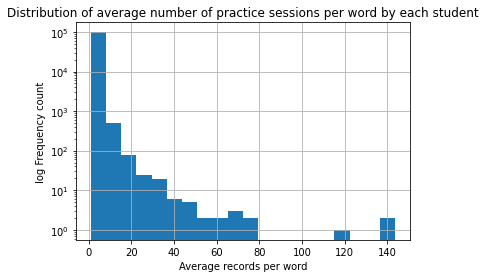

In [ ]:
plt.figure()
plt.title("Distribution of average number of practice sessions per word by each student")
plt.xlabel("Average records per word")
plt.ylabel("log Frequency count")
student_details['Average_rec_per_word'].hist(log=True,bins=20)
plt.show()

The distribution of the number of records per word for each student is skewed to the right. Most students had fewer than 10 records per word. 

The distribution of number of words learned per student is below: (log scale)

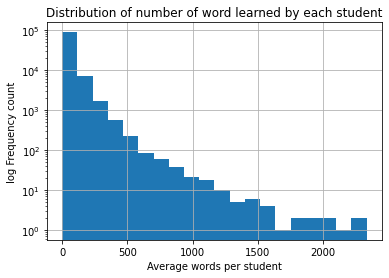

In [ ]:
plt.figure()
plt.title("Distribution of number of word learned by each student")
plt.xlabel("Average words per student")
plt.ylabel("log Frequency count")
student_details['num_words'].hist(log=True,bins=20)
plt.show()

Most students practiced ~0- 100 words in the two week period. 

The distribution of number of records is below:

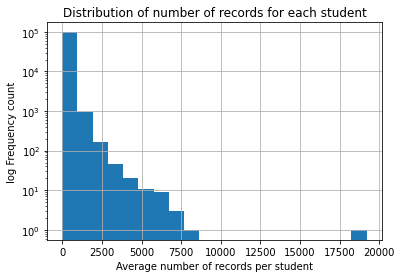

In [ ]:
plt.figure()
plt.title("Distribution of number of records for each student")
plt.xlabel("Average number of records per student")
plt.ylabel("log Frequency count")
student_details['num_records'].hist(log=True,bins=20)
plt.show()

Most students have less than 1000 records, although there are around 10 students with > 17,500 records. 

Splitting will be done keeping in mind that the average records per word should be a similar distribution for the training and test set, for each language. This is done so that the students of one language are not over or under represented in the training set. 

The process will be:
1. Calculate the average records per word for each student
2. get lists of students in each language course (one course represents a pairing of native language and learning language)
3. For each language course, 10% of the students are kept aside in a manner that keeps the distribution of average records per word the same in the train and test sets.
4. The 10% of students for each language course are combined to make the Q2 test set of unseen students. The rest will form the Q2 TRAIN set. 

Now we will get the language course for each student.

In [ ]:
lang_pairs = list(zip(datadf2_oneui['ui_language'],datadf2_oneui['learning_language']))
stud_lang_dict = dict(zip(list(datadf2_oneui['user_id']),lang_pairs))

In [ ]:
len(stud_lang_dict.keys())

98693

In [ ]:
student_details = student_details.reset_index()
student_details.head()

,user_id,num_words,num_records,Average_rec_per_word
0,u:-3I,13,14,1.076923
1,u:-3n,112,124,1.107143
2,u:-4V,13,26,2.000000
3,u:-4y,26,68,2.615385
4,u:-69,15,15,1.000000


In [ ]:
student_details['lang_group'] = student_details['user_id'].map(stud_lang_dict)

In [ ]:
student_details.head()

,user_id,num_words,num_records,Average_rec_per_word,lang_group
0,u:-3I,13,14,1.076923,"(en, fr)"
1,u:-3n,112,124,1.107143,"(en, es)"
2,u:-4V,13,26,2.000000,"(en, fr)"
3,u:-4y,26,68,2.615385,"(en, es)"
4,u:-69,15,15,1.000000,"(en, fr)"


We will go through each language group (ui , learning langugae), and get a random cut of 10% of the students, stratifying by average records per word. 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
lang_pair_counts

user_id  testset_counts
learning_language ui_language                         
en                es             31613          3161.3
                  pt              8591           859.1
es                en             31104          3110.4
fr                en             19878          1987.8
it                en              6463           646.3
pt                en              2679           267.9

We will filter by each language group and split students.

### <font color='cornflowerblue' size=2>English to Spanish</font>

In [ ]:
en_to_es = student_details.loc[student_details['lang_group']==('en','es')]
en_to_es_remaining, en_to_es_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_es[['user_id','num_words','num_records']],en_to_es['Average_rec_per_word'],test_size=0.1,random_state=5)

In [ ]:
en_to_es_unseen_students['Average_rec_per_word'] = y_unseen_students

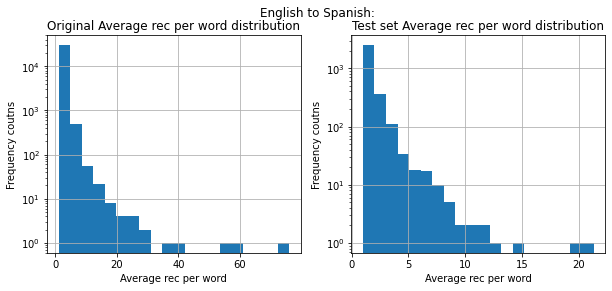

In [ ]:
plt.subplots(1,2,figsize=(10,4))
plt.suptitle("English to Spanish:")
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
en_to_es['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
en_to_es_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)
plt.show()

In [ ]:
en_to_es_unseen_students.shape

(3055, 4)

The distributions are similar for the training and test set. 

The same process is followed for the other language groups, and then get the groups of user_id for training and testing, then split the datadf2 dataframe accordingly. 

### <font color = cornflowerblue size=2>English to Portuguese</font>

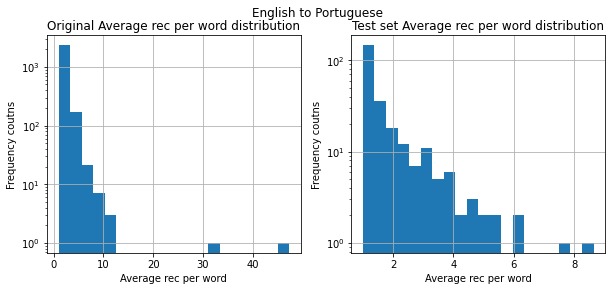

In [ ]:
en_to_pt = student_details.loc[student_details['lang_group']==('en','pt')]
en_to_pt_remaining, en_to_pt_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_pt[['user_id','num_words','num_records']],en_to_pt['Average_rec_per_word'],test_size=0.1,random_state=5)
en_to_pt_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.suptitle("English to Portuguese")
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
en_to_pt['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
en_to_pt_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)
plt.show()

In [ ]:
en_to_pt_unseen_students.shape

(254, 4)

### <font color = cornflowerblue size=2>Spanish to English</font>

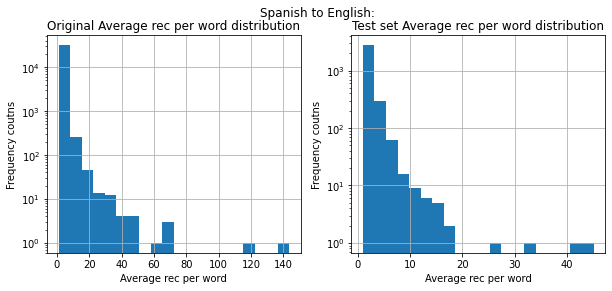

In [ ]:
es_to_en = student_details.loc[student_details['lang_group']==('es','en')]
es_to_en_remaining, es_to_en_unseen_students, y_remaining, y_unseen_students = train_test_split(es_to_en[['user_id','num_words','num_records']],es_to_en['Average_rec_per_word'],test_size=0.1,random_state=5)
es_to_en_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("Spanish to English:")
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
es_to_en['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
es_to_en_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)
plt.show()

### <font color = cornflowerblue size=2>English to French</font>

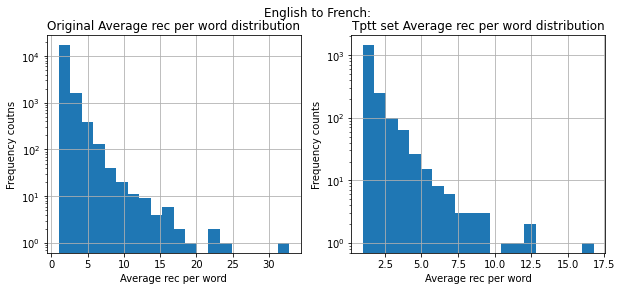

In [ ]:
en_to_fr = student_details.loc[student_details['lang_group']==('en','fr')]
en_to_fr_remaining, en_to_fr_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_fr[['user_id','num_words','num_records']],en_to_fr['Average_rec_per_word'],test_size=0.1,random_state=5)
en_to_fr_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("English to French:")
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
en_to_fr['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency counts")
en_to_fr_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)
plt.show()

In [ ]:
en_to_fr_unseen_students.shape

(1924, 4)

### <font color = cornflowerblue size=2>English to Italian</font>

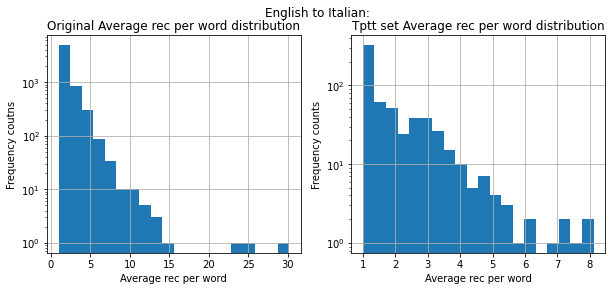

In [ ]:
en_to_it = student_details.loc[student_details['lang_group']==('en','it')]
en_to_it_remaining, en_to_it_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_it[['user_id','num_words','num_records']],en_to_it['Average_rec_per_word'],test_size=0.1,random_state=5)
en_to_it_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("English to Italian:")
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
en_to_it['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency counts")
en_to_it_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

In [ ]:
en_to_it_unseen_students.shape

(617, 4)

### <font color = cornflowerblue size=2>Portuguese to English</font>

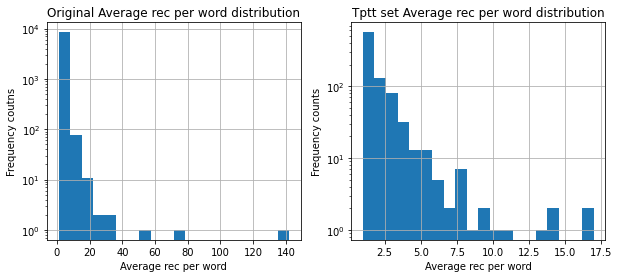

In [ ]:
pt_to_en = student_details.loc[student_details['lang_group']==('pt','en')]
pt_to_en_remaining, pt_to_en_unseen_students, y_remaining, y_unseen_students = train_test_split(pt_to_en[['user_id','num_words','num_records']],pt_to_en['Average_rec_per_word'],test_size=0.1,random_state=5)
pt_to_en_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency coutns")
pt_to_en['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("log Frequency counts")
pt_to_en_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

In [ ]:
pt_to_en_unseen_students.shape

(860, 4)

### <font color = cornflowerblue size=2>Combining all language courses</font>
Combining the list of students set aside for the test set into a single list.

In [ ]:
unseen_students = list(en_to_es_unseen_students['user_id']) + list(en_to_pt_unseen_students['user_id'])\
+list(es_to_en_unseen_students['user_id']) + list(en_to_fr_unseen_students['user_id'])\
+list(en_to_it_unseen_students['user_id']) + list(pt_to_en_unseen_students['user_id'])

In [ ]:
unseen_students = set(unseen_students)

Now we have the test set user_id, the dataframe is split into train and test: 

In [ ]:
unseen_students_test_set = datadf2.loc[datadf2['user_id'].isin(unseen_students),:]
unseen_students_test_set.shape

(1124568, 17)

In [ ]:
unseen_students_test_set.shape[0]/datadf2.shape[0]*100

10.244396758575531

After removing 10% of the students from each language course in a manner that the number of records per word is about the same, the dataset with all records has a similar split ratio. 

We have 10% of the dataset set apart for unseen students. We will save it as a compressed pickle file.

In [ ]:
unseen_students_test_set.columns

Index(['timestamp', 'delta', 'user_id', 'learning_language', 'ui_language',
       'lexeme_id', 'lexeme_string', 'history_seen', 'history_correct',
       'session_seen', 'session_correct', 'p_forgot_bin', 'Datetime',
       'delta_days', 'history_frac', 'binned_hfrac', 'student_lang'],
      dtype='object')

student_lang column is no longer needed and can be dropped. 

In [ ]:
unseen_students_test_set = unseen_students_test_set.drop('student_lang',axis=1)

In [ ]:
compressed_pickle(path_name+'Q2TEST',unseen_students_test_set)

The remainder is saved as the training set

In [ ]:
datadf2.columns

Index(['timestamp', 'delta', 'user_id', 'learning_language', 'ui_language',
       'lexeme_id', 'lexeme_string', 'history_seen', 'history_correct',
       'session_seen', 'session_correct', 'p_forgot_bin', 'Datetime',
       'delta_days', 'history_frac', 'binned_hfrac', 'student_lang'],
      dtype='object')

In [ ]:
datadf2.shape

(9852828, 16)

In [ ]:
datadf2 = datadf2.drop('student_lang',axis=1)
datadf2 = datadf2.drop(unseen_students_test_set.index)
compressed_pickle(path_name+"Q2TRAIN",datadf2)

Since the unseen students test set is no longer needed, it is deleted

In [ ]:
del unseen_students_test_set

## <font color='cornflowerblue' size=4>Splitting for Q1 - unseen words</font>

The approach to splitting for unseen words will be similar to the approach for splitting for unseen students. 

The distribution of number of records per lexeme should be about the same for the training and test sets for each language. This is done so that there are some rarely learned words, and heavily practiced words in both the training and test set. 

Process:
1. Get the number of lexemes for each learning language
2. Compute the number of practice sessions for each lexeme
3. For each language, set aside 15% of the words, such that the distribution of number of records per lexeme is about the same in training and test set. 

Since the RAM is almost full, runtime is restarted, and after mounting google drive, the Q2TRAIN dataset is reloaded to be further split into Q1TRAIN and Q1TEST. 

In [ ]:
datadf3 = decompress_pickle(path_name+"Q2TRAIN.pbz2")

In [ ]:
datadf3.shape

(9852828, 16)

1. get number of records per word, number of students per word, language pair. 
2. For each language pair, get a 15% split. 

In [ ]:
# series indexed by the language course, with values = number of unique words in the course
num_lexemes = datadf3.groupby(['ui_language','learning_language'])['lexeme_string'].unique().apply(len)

In [ ]:
num_lexemes

ui_language  learning_language
en           es                   3297
             fr                   4125
             it                   2173
             pt                   2692
es           en                   2864
pt           en                   2811
Name: lexeme_string, dtype: int64

A function is degined to get the unique values in a series:

In [ ]:
def uniquelen(ser):
  return len(ser.unique())

### <font color = 'cornflowerblue' size=2>English to Spanish:</font>

Computing average number of students and average number of records for each lexeme in the English to Spanish course:

In [ ]:
en_to_es = datadf3.loc[(datadf3['ui_language']=='en') & (datadf3['learning_language']=='es'),:].groupby(['lexeme_string']).agg(Num_students=pd.NamedAgg('user_id',uniquelen), Num_records = pd.NamedAgg('user_id','count'))
en_to_es.head()

,Num_students,Num_records
lexeme_string,,
<*sf>/abogado<n><m><*numb>,578,900
<*sf>/acción<n><f><*numb>,24,29
<*sf>/actitud<n><f><*numb>,13,14
<*sf>/actividad<n><f><*numb>,28,36
<*sf>/acto<n><m><*numb>,24,25


Plotting the number of records per student for each word. Represents on average how much the word was practiced. 

In [ ]:
en_to_es['Avg_rec_per_stud'] = en_to_es['Num_records']/en_to_es['Num_students']

The distribution of the average number of practice sessions for each lexeme is plotted below: (log scale)

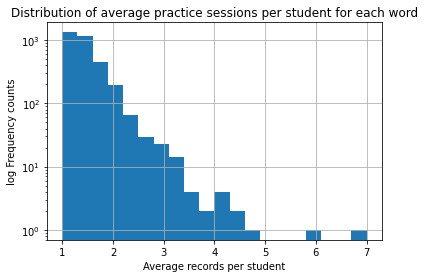

In [ ]:
plt.figure()
plt.title("Distribution of average practice sessions per student for each word")
plt.xlabel("Average records per student")
plt.ylabel("log Frequency counts")
en_to_es['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.show()

Most words were practiced 1 or 2 times. The distribution is skewed to the right. 

Splitting the words, stratifying for number of records per student for each word:

In [ ]:
from sklearn.model_selection import train_test_split

en_to_es_remaining,en_to_es_unseen_words,y_remaining,y_unseen_words = train_test_split(en_to_es[['Num_students','Num_records']],en_to_es['Avg_rec_per_stud'],test_size=0.15,random_state=5)

In [ ]:
en_to_es_unseen_words['Avg_rec_per_stud'] = y_unseen_words

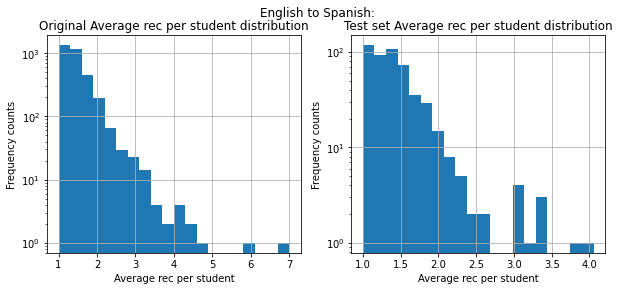

In [ ]:
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("English to Spanish:")
plt.title("Original Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_es['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_es_unseen_words['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.show()

The words in the train and test for English to Spanish show a similar distribution if records per student. 

This process is repeated for each language course.

### <font color = 'cornflowerblue' size=2>English to French:</font>

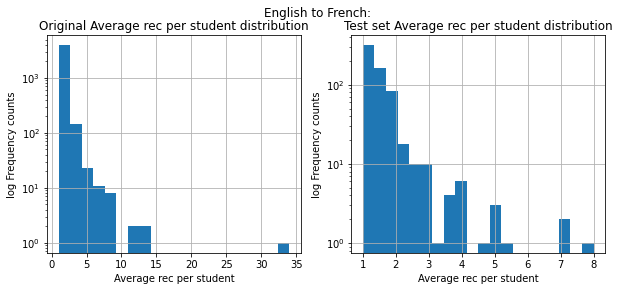

In [ ]:
en_to_fr = datadf3.loc[(datadf3['ui_language']=='en') & (datadf3['learning_language']=='fr'),:].groupby(['lexeme_string']).agg(Num_students=pd.NamedAgg('user_id',uniquelen), Num_records = pd.NamedAgg('user_id','count'))
en_to_fr['Avg_rec_per_stud'] = en_to_fr['Num_records']/en_to_fr['Num_students']
en_to_fr_remaining,en_to_fr_unseen_words,y_remaining,y_unseen_words = train_test_split(en_to_fr[['Num_students','Num_records']],en_to_fr['Avg_rec_per_stud'],test_size=0.15,random_state=5)
en_to_fr_unseen_words['Avg_rec_per_stud'] = y_unseen_words
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("English to French:")
plt.suptitle("English to French:")
plt.title("Original Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_fr['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_fr_unseen_words['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.show()

### <font color = 'cornflowerblue' size=2>English to Italian:</font>

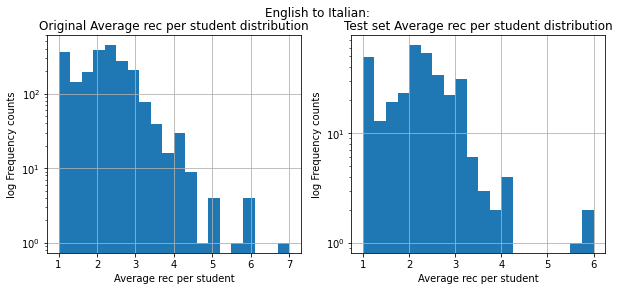

In [ ]:
en_to_it = datadf3.loc[(datadf3['ui_language']=='en') & (datadf3['learning_language']=='it'),:].groupby(['lexeme_string']).agg(Num_students=pd.NamedAgg('user_id',uniquelen), Num_records = pd.NamedAgg('user_id','count'))
en_to_it['Avg_rec_per_stud'] = en_to_it['Num_records']/en_to_it['Num_students']
en_to_it_remaining,en_to_it_unseen_words,y_remaining,y_unseen_words = train_test_split(en_to_it[['Num_students','Num_records']],en_to_it['Avg_rec_per_stud'],test_size=0.15,random_state=5)
en_to_it_unseen_words['Avg_rec_per_stud'] = y_unseen_words
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("English to Italian:")
plt.title("Original Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_it['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_it_unseen_words['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.show()

### <font color = 'cornflowerblue' size=2>English to Portuguese:</font>

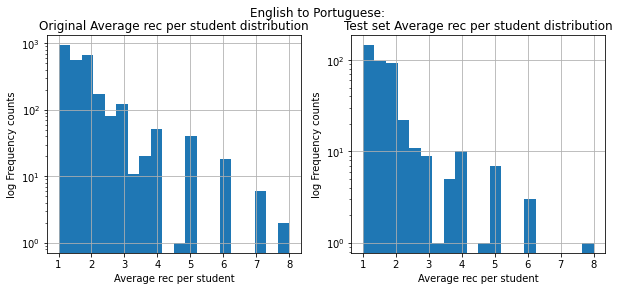

In [ ]:
en_to_pt = datadf3.loc[(datadf3['ui_language']=='en') & (datadf3['learning_language']=='pt'),:].groupby(['lexeme_string']).agg(Num_students=pd.NamedAgg('user_id',uniquelen), Num_records = pd.NamedAgg('user_id','count'))
en_to_pt['Avg_rec_per_stud'] = en_to_pt['Num_records']/en_to_pt['Num_students']
en_to_pt_remaining,en_to_pt_unseen_words,y_remaining,y_unseen_words = train_test_split(en_to_pt[['Num_students','Num_records']],en_to_pt['Avg_rec_per_stud'],test_size=0.15,random_state=5)
en_to_pt_unseen_words['Avg_rec_per_stud'] = y_unseen_words
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("English to Portuguese:")
plt.title("Original Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_pt['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
en_to_pt_unseen_words['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.show()

### <font color = 'cornflowerblue' size=2>Portuguese to English:</font>

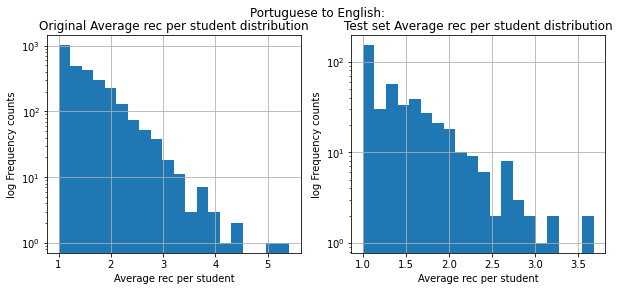

In [ ]:
pt_to_en = datadf3.loc[(datadf3['ui_language']=='pt') & (datadf3['learning_language']=='en'),:].groupby(['lexeme_string']).agg(Num_students=pd.NamedAgg('user_id',uniquelen), Num_records = pd.NamedAgg('user_id','count'))
pt_to_en['Avg_rec_per_stud'] = pt_to_en['Num_records']/pt_to_en['Num_students']
pt_to_en_remaining,pt_to_en_unseen_words,y_remaining,y_unseen_words = train_test_split(pt_to_en[['Num_students','Num_records']],pt_to_en['Avg_rec_per_stud'],test_size=0.15,random_state=5)
pt_to_en_unseen_words['Avg_rec_per_stud'] = y_unseen_words
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("Portuguese to English:")
plt.title("Original Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
pt_to_en['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
pt_to_en_unseen_words['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.show()

### <font color = 'cornflowerblue' size=2>Spanish to English:</font>

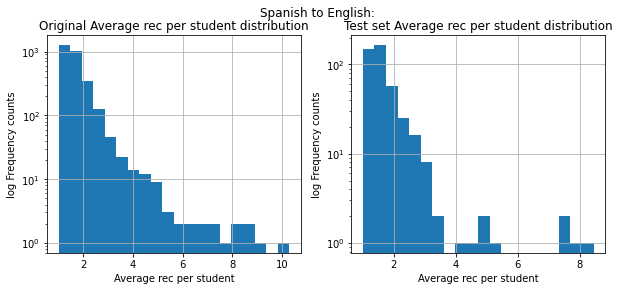

In [ ]:
es_to_en = datadf3.loc[(datadf3['ui_language']=='es') & (datadf3['learning_language']=='en'),:].groupby(['lexeme_string']).agg(Num_students=pd.NamedAgg('user_id',uniquelen), Num_records = pd.NamedAgg('user_id','count'))
es_to_en['Avg_rec_per_stud'] = es_to_en['Num_records']/es_to_en['Num_students']
es_to_en_remaining,es_to_en_unseen_words,y_remaining,y_unseen_words = train_test_split(es_to_en[['Num_students','Num_records']],es_to_en['Avg_rec_per_stud'],test_size=0.15,random_state=5)
es_to_en_unseen_words['Avg_rec_per_stud'] = y_unseen_words
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.suptitle("Spanish to English:")
plt.title("Original Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
es_to_en['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per student distribution")
plt.xlabel("Average rec per student")
plt.ylabel("log Frequency counts")
es_to_en_unseen_words['Avg_rec_per_stud'].hist(log=True,bins=20)
plt.show()

### <font color = 'cornflowerblue' size=2>Combining words from all languages</font>

The words kept aside from each language course are now combined to form the list of words in the unseen words test set. The rest wil be the training set. 

In [ ]:
unseen_words = list(en_to_es_unseen_words.index) + list(en_to_pt_unseen_words.index)\
+list(es_to_en_unseen_words.index) + list(en_to_fr_unseen_words.index)\
+list(en_to_it_unseen_words.index) + list(pt_to_en_unseen_words.index)

In [ ]:
datadf3.columns

Index(['timestamp', 'delta', 'user_id', 'learning_language', 'ui_language',
       'lexeme_id', 'lexeme_string', 'history_seen', 'history_correct',
       'session_seen', 'session_correct', 'p_forgot_bin', 'Datetime',
       'delta_days', 'history_frac', 'binned_hfrac'],
      dtype='object')

In [ ]:
unseen_words_set = datadf3.loc[datadf3['lexeme_string'].isin(unseen_words),:]

In [ ]:
# dimensions of unseen words test set. 
unseen_words_set.shape

(1977241, 16)

In [ ]:
# Percentage size of test set compared to main dataframe:
unseen_words_set.shape[0]/datadf3.shape[0]*100

20.067751106585845

In [ ]:
datadf3 = datadf3.drop(unseen_words_set.index)

In [ ]:
datadf3.shape

(7875587, 16)

By keeping aside 15% of the words by stratifying records per student for each language course, a train-test distribution of the main dataframe of 80-20 is obtained. 

Train and test sets are saved as compressed pickle files. 

In [ ]:
compressed_pickle(path_name+"Q1TRAIN",datadf3)

In [ ]:
compressed_pickle(path_name+"Q1TEST",unseen_words_set)

## <font color = 'cornflowerblue' size=4>Conclusions and next steps</font>

The dataset has been split to answer the three questions asked in the project. 

Care has been taken to ensure that heavily practiced and rarely learned words are similarly distributed in the training and test set for the unseen words question (Q1)

A similar distribution of regular and irregular students has been maintained for the train and test splits of Q2.

Unseen languages have been kept aside (selected for low and high lexical similarity with English) for Q3. 

The number of records (in millions) of the various sets is summarized in the table below. 

|    	| Train 	| Test 	| Sum   	|
|----	|-------	|------	|-------	|
| Q1 	| 7.88  	| 1.97 	| 9.85  	|
| Q2 	| 9.85  	| 1.12 	| 10.97 	|
| Q3 	| 10.97 	| 1.88 	| 12.85 	|

**Next steps**

1. Preprocessing train and test sets for Q1:
- modifier and part-of-speech one-hot encodings
- PCA

2. Model development for Q1. 
- Classical
- Ensemble
- Dense Neural net 